In [1]:
from pathgen.utils.seeds import set_seed
from pathgen.utils.paths import project_root

experiment_name = "one"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 123
set_seed(global_seed)

In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
from torch import nn
import torch.nn.functional as F
from pytorch_lightning.metrics import Accuracy

def accuracy(logits, y):
    # pred = torch.log_softmax(logits, dim=1)
    # correct = pred.argmax(dim=1).eq(y).sum().item()
    correct = logits.argmax(dim=1).eq(y).sum().item()
    total = len(y)
    accu = correct / total
    return accu


class PatchClassifier(pl.LightningModule):
    def __init__(self, model, learning_rate=2e-4) -> None:
        super().__init__()
        self.model = model
        #self.accuracy = Accuracy()
        self.accuracy = accuracy
        
        # log hyperparameters
        # self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.test_pred = []
        self.test_y = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        acc = accuracy(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        acc = accuracy(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        
        # log the results so we can compute epoch wide metrics
        pred = logits.argmax(dim=1)
        pred_list = pred.cpu().numpy().tolist()
        #print(pred_list)
        y_list = y.cpu().numpy().tolist()
        #print(y_list)
        self.test_pred.append(pred_list)
        self.test_y.append(y_list)
        
        # training metrics
        acc = accuracy(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), 
                                    lr=0.01, 
                                    momentum=0.9, 
                                    weight_decay=0.0005)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=50000, gamma=0.5),
            'interval': 'step' 
        }
        return [optimizer], [scheduler]
    
    #def configure_optimizers(self):
     #  optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #return optimizer    

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

class Backbone(nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x

In [4]:
%%time

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torchvision.transforms as transforms

# prepare our data
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train_set = ImageFolder(experiment_root / "training_patches", transform=transform)
# valid_set = ImageFolder(experiment_root / "validation_patches", transform=transform)

dataset = ImageFolder(project_root() / 'experiments/one/fake_patches', transform=transform)  # 60,000 samples
train_set, valid_set = torch.utils.data.random_split(dataset, [50000, 10000])

train_loader = DataLoader(train_set, batch_size=batch_size, worker_init_fn=np.random.seed(global_seed), num_workers=32)
valid_loader = DataLoader(valid_set, batch_size=batch_size, worker_init_fn=np.random.seed(global_seed), num_workers=32)



CPU times: user 551 ms, sys: 42.9 ms, total: 593 ms
Wall time: 450 ms


In [5]:
# configure logging and checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=experiment_root / "patch_model",
    filename=f"checkpoint.ckpt",
    save_top_k=1,
    mode="min",
)

#early_stop_callback = EarlyStopping(
#    monitor='val_accuracy',
#    min_delta=0.00,
#    patience=5,
#    verbose=False,
#    mode='max'
#)

csv_logger = pl_loggers.CSVLogger(experiment_root / 'logs', name='patch_classifier_fake', version=0)

# train our model
model = Backbone((3, 64, 64), 2)
classifier = PatchClassifier(model)
trainer = pl.Trainer(callbacks=[checkpoint_callback], log_every_n_steps=50, gpus=1, max_epochs=10, logger=csv_logger, auto_select_gpus=False)
trainer.fit(classifier, train_dataloader=train_loader, val_dataloaders=valid_loader)

/home/ubuntu/anaconda3/envs/pathgen/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/ubuntu/pathgen/experiments/one/patch_model exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/ubuntu/anaconda3/envs/pathgen/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Experiment logs directory /home/ubuntu/pathgen/experiments/one/logs/patch_classifier_fake/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | Backbone | 5.7 M 
-----------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.679    Total estimated model params size (MB)


Epoch 0:  83%|████████▎ | 1563/1876 [00:27<00:05, 56.13it/s, loss=0.0111, v_num=0, val_loss=0.693, val_acc=0.516, train_loss=0.00128, train_acc=1.000]   
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████▎ | 1563/1876 [00:27<00:05, 55.85it/s, loss=0.0163, v_num=0, val_loss=0.00315, val_acc=0.999, train_loss=0.000599, train_acc=1.000]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████▎ | 1563/1876 [00:27<00:05, 56.62it/s, loss=0.000339, v_num=0, val_loss=0.00177, val_acc=1.000, train_loss=0.000116, train_acc=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|████████▎ | 1563/1876 [00:27<00:05, 56.39it/s, loss=0.000226, v_num=0, val_loss=0.000327, val_acc=1.000, train_loss=0.000128, train_acc=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|████████▎ | 1563/1876 [00:27<00:05, 56.63it/s, loss=7.11e-05, v_num=0, val_loss=0.00042, val_acc=1.000, train_loss=3.8e-5, train_acc=1.000]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|████████▎ | 1563/1876 [00:26<00:05, 59.98it/s, loss=

Epoch 8:  83%|████████▎ | 1564/1876 [00:17<00:03, 91.31it/s, loss=4.61e-05, v_num=0, val_loss=0.000113, val_acc=1.000, train_loss=2.47e-5, train_acc=1.000] 
Validating: 0it [00:00, ?it/s]
Epoch 9:  83%|████████▎ | 1564/1876 [00:17<00:03, 91.24it/s, loss=4.25e-05, v_num=0, val_loss=0.000122, val_acc=1.000, train_loss=2.56e-5, train_acc=1.000] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 1876/1876 [00:20<00:00, 92.78it/s, loss=4.25e-05, v_num=0, val_loss=0.000109, val_acc=1.000, train_loss=4.46e-5, train_acc=1.000]


1

In [21]:
# test
test_set = ImageFolder(experiment_root / 'camelyon16_patches/test', transform=transform)
test_loader = DataLoader(train_set, batch_size=batch_size, worker_init_fn=np.random.seed(global_seed), num_workers=32)
trainer.test(test_dataloaders=test_loader)

Testing: 100%|██████████| 1563/1563 [00:07<00:00, 199.82it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9999600052833557, 'test_loss': 0.00014884828124195337}
--------------------------------------------------------------------------------


[{'test_loss': 0.00014884828124195337, 'test_acc': 0.9999600052833557}]

In [7]:
len(test_set)

20000

In [8]:
import pandas as pd

log_df = pd.read_csv(experiment_root / 'logs/patch_classifier_fake/version_0/metrics.csv')
log_df

,train_loss,train_acc,epoch,step,val_loss,val_acc,test_loss,test_acc
0,0.663702,0.56250,0,49,NaN,NaN,NaN,NaN
1,0.633575,0.68750,0,99,NaN,NaN,NaN,NaN
2,0.234382,0.90625,0,149,NaN,NaN,NaN,NaN
3,0.245373,0.93750,0,199,NaN,NaN,NaN,NaN
4,0.004402,1.00000,0,249,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
318,0.000453,1.00000,9,15499,NaN,NaN,NaN,NaN
319,0.000398,1.00000,9,15549,NaN,NaN,NaN,NaN
320,0.000005,1.00000,9,15599,NaN,NaN,NaN,NaN
321,NaN,NaN,9,15629,0.000109,1.0,NaN,NaN


In [9]:
log_df['val_loss'].dropna()

31     0.003147
63     0.001766
95     0.000327
128    0.000420
160    0.000109
192    0.000115
224    0.000466
257    0.000113
289    0.000122
321    0.000109
Name: val_loss, dtype: float64

Text(0, 0.5, 'loss')

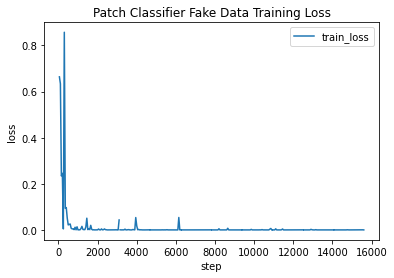

In [16]:
%matplotlib inline
ax = log_df[['train_loss','step']].plot(x='step', title='Patch Classifier Fake Data Training Loss')
ax.set_ylabel('loss')

Text(0, 0.5, 'loss')

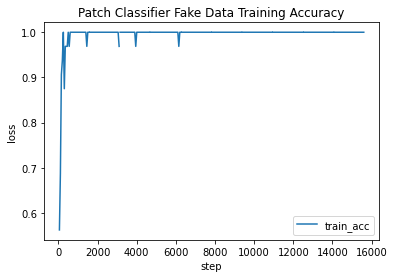

In [19]:
ax = log_df[['train_acc','step']].plot(x='step', title='Patch Classifier Fake Data Training Accuracy')
ax.set_ylabel('loss')

In [12]:
len(classifier.test_pred), len(classifier.test_y)
expected = [x for xs in classifier.test_y for x in xs]
predicted = [x for xs in classifier.test_pred for x in xs] 

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     24932
       tumor       1.00      1.00      1.00     25068

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



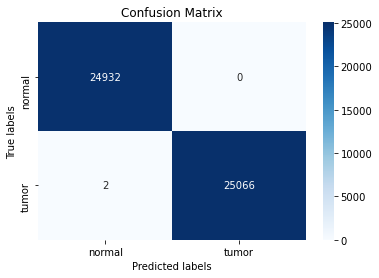

In [13]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

print(metrics.classification_report(expected, predicted, labels=[0, 1], target_names=['normal', 'tumor']))

cm = metrics.confusion_matrix(expected, predicted)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'tumor']); ax.yaxis.set_ticklabels(['normal', 'tumor']);